# Exercise 2: Convolution GAN for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [25]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


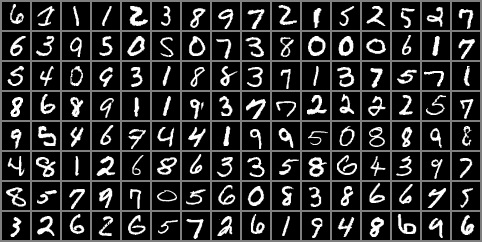

In [26]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

**Answer:**

The provided code defines a DCGAN architecture for generating and discriminating MNIST digits. The **Generator** uses a series of transposed convolutional layers to upscale a 100-dimensional noise vector into a 28x28 image, employing batch normalization and ReLU activation, with a final Tanh layer to normalize outputs. The **Discriminator** down-samples input images through convolutional layers, utilizing Leaky ReLU and batch normalization to enhance training stability. Both models are designed to handle the typical challenges of training GANs, such as maintaining gradient flow and training stability. Adjustments may be necessary in the generator's final layer to ensure proper output dimensions.

In [27]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


## Display Samples of the Generator

In [28]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

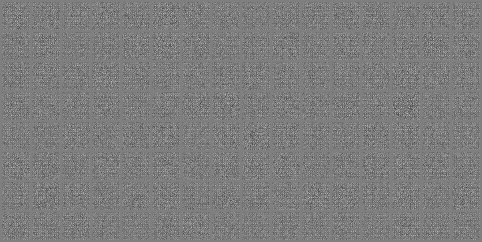

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [30]:
def lipconstant(D, x, y):
    """ Approximate the Lipschitz constant for diagnostic purposes. """
    # Create interpolated images
    alpha = torch.rand(y.size(0), 1, 1, 1, device=y.device)
    alpha = alpha.expand_as(y)
    interpolated = alpha * y + (1 - alpha) * x
    interpolated.requires_grad_(True)

    # Calculate discriminator output
    d_interpolated = D(interpolated)

    # Calculate gradients
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(d_interpolated.size(), device=interpolated.device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    # Return the maximum gradient norm (proxy for Lipschitz constant)
    return gradients.norm(2, dim=1).max()

def gradient_penalty(D, real_images, fake_images, lambda_gp=10):
    """ Compute the gradient penalty for a batch of real and fake images. """
    alpha = torch.rand(real_images.size(0), 1, 1, 1, device=real_images.device)
    alpha = alpha.expand_as(real_images)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    interpolated.requires_grad_(True)

    # Critic scores for interpolated images
    d_interpolated = D(interpolated)

    # Compute gradients
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(d_interpolated.size(), device=real_images.device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty


y = next(iter(train_loader))[0].to(device)  # Real images
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()  # Generated images

print("Lipschitz constant approximation:", lipconstant(D, x, y))
print("Gradient penalty:", gradient_penalty(D, y, x))

Lipschitz constant approximation: tensor(2.1280, device='cuda:0', grad_fn=<MaxBackward1>)
Gradient penalty: tensor(7.7600, device='cuda:0', grad_fn=<MulBackward0>)


[1/5][0/468][0.4015 s]	Loss_D: 0.5886	Loss_G: 0.2132	Lip(D): 1.8685


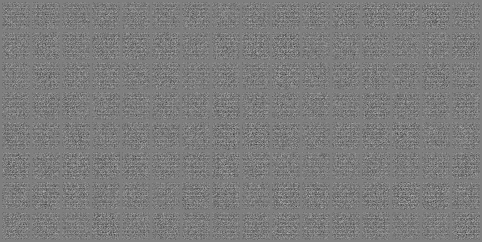

[1/5][100/468][11.7892 s]	Loss_D: -8.4315	Loss_G: 0.4986	Lip(D): 2.1978


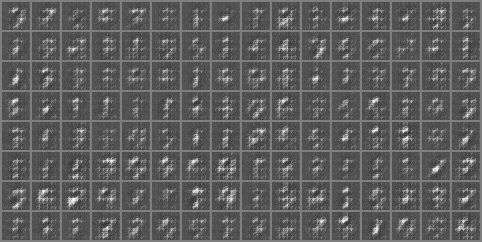

[1/5][200/468][23.4032 s]	Loss_D: -42.1258	Loss_G: 16.5915	Lip(D): 3.7439


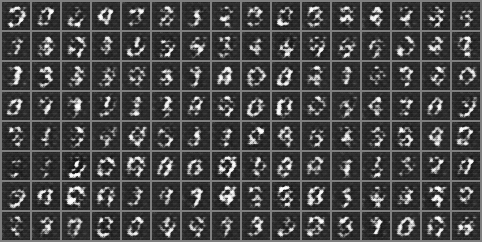

[1/5][300/468][34.9808 s]	Loss_D: -54.1435	Loss_G: 26.3977	Lip(D): 4.7867


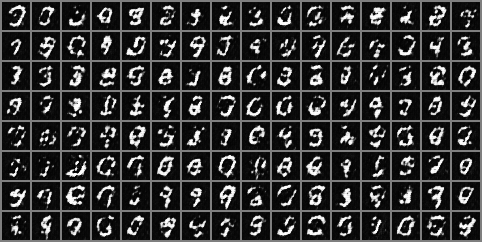

[1/5][400/468][46.3761 s]	Loss_D: -38.4267	Loss_G: 31.6732	Lip(D): 4.4300


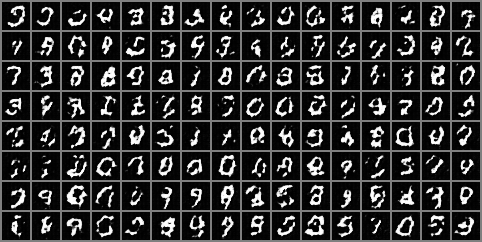

[2/5][0/468][54.1734 s]	Loss_D: -41.1389	Loss_G: 56.0060	Lip(D): 5.0196


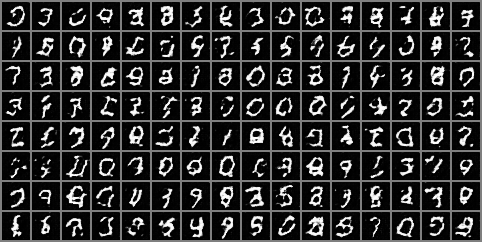

[2/5][100/468][65.4243 s]	Loss_D: -25.7695	Loss_G: 13.2479	Lip(D): 6.6015


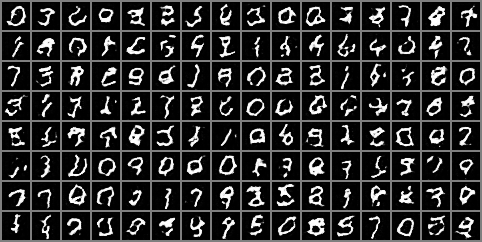

[2/5][200/468][76.6677 s]	Loss_D: -31.0691	Loss_G: 53.7026	Lip(D): 5.6132


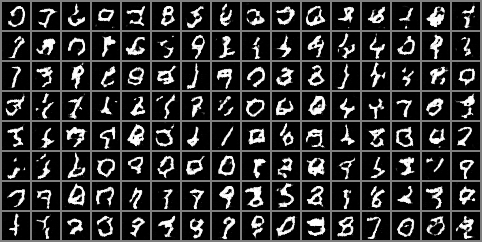

[2/5][300/468][87.9801 s]	Loss_D: -45.2057	Loss_G: -10.9653	Lip(D): 8.9197


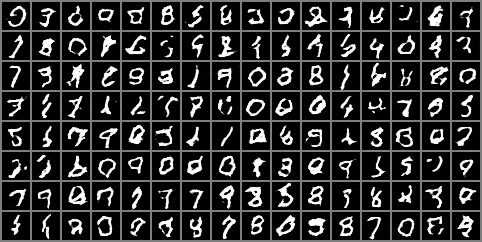

[2/5][400/468][99.3562 s]	Loss_D: -31.5708	Loss_G: 54.8632	Lip(D): 5.5751


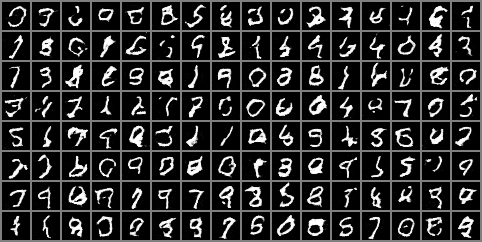

[3/5][0/468][107.2399 s]	Loss_D: -37.6067	Loss_G: 11.7369	Lip(D): 9.7584


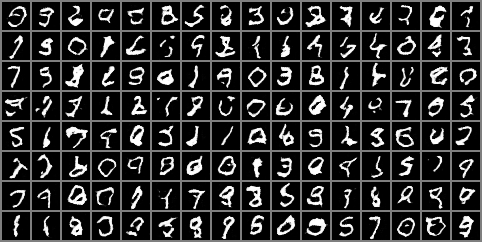

[3/5][100/468][118.5897 s]	Loss_D: -22.9685	Loss_G: -9.0773	Lip(D): 4.2479


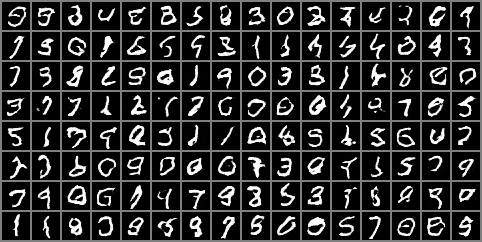

[3/5][200/468][129.9334 s]	Loss_D: -2.1127	Loss_G: 62.6404	Lip(D): 4.4962


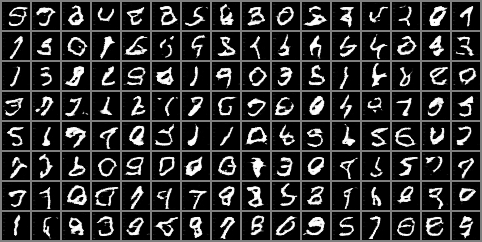

[3/5][300/468][141.2491 s]	Loss_D: -38.1474	Loss_G: 42.0636	Lip(D): 4.8991


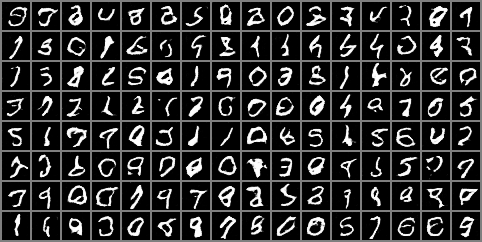

[3/5][400/468][152.5453 s]	Loss_D: -30.7011	Loss_G: 35.8446	Lip(D): 7.5420


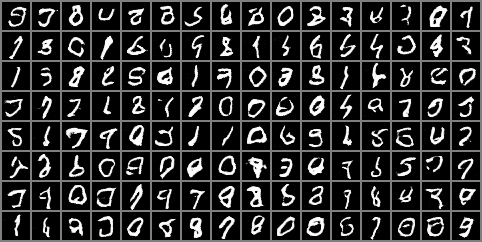

[4/5][0/468][160.3303 s]	Loss_D: -23.9485	Loss_G: 49.9482	Lip(D): 4.1321


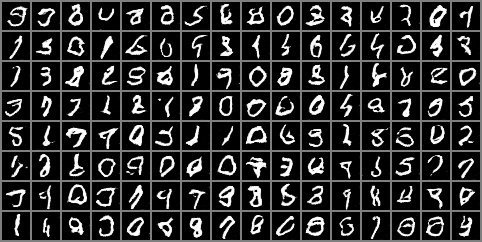

[4/5][100/468][171.6200 s]	Loss_D: -30.7441	Loss_G: -5.6152	Lip(D): 3.9619


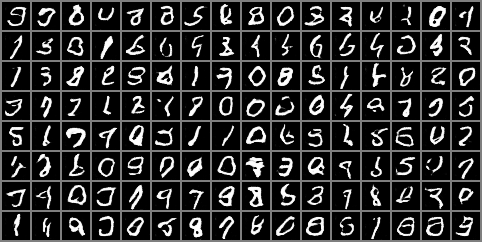

[4/5][200/468][182.9543 s]	Loss_D: -36.7434	Loss_G: 39.2914	Lip(D): 3.3847


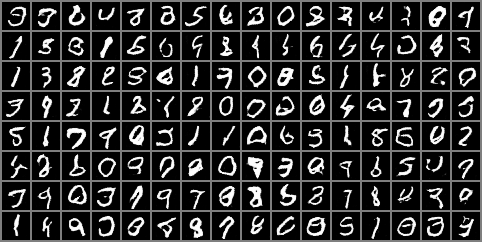

[4/5][300/468][194.3030 s]	Loss_D: -26.2442	Loss_G: 13.7803	Lip(D): 5.8437


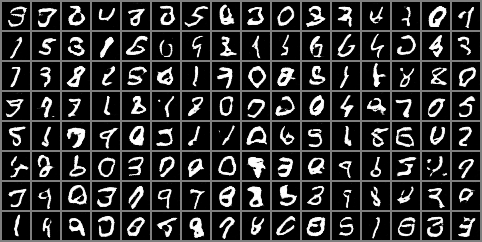

[4/5][400/468][205.6611 s]	Loss_D: -8.9725	Loss_G: 85.8412	Lip(D): 3.6749


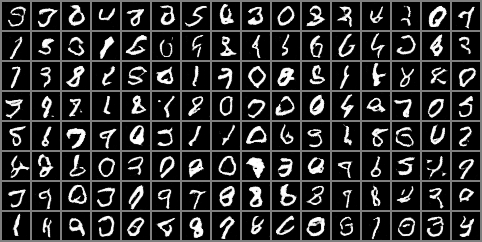

[5/5][0/468][213.4950 s]	Loss_D: -9.1663	Loss_G: 40.0801	Lip(D): 4.4575


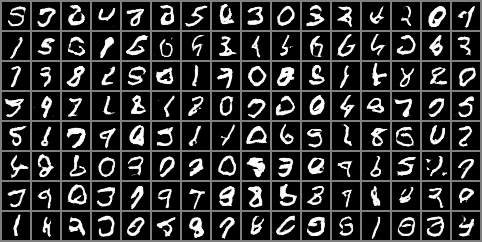

[5/5][100/468][224.8145 s]	Loss_D: -17.8309	Loss_G: 11.0253	Lip(D): 8.9319


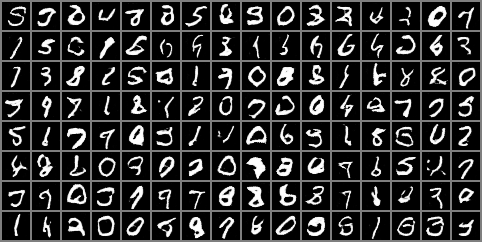

[5/5][200/468][236.1563 s]	Loss_D: -19.6564	Loss_G: 1.5483	Lip(D): 5.6419


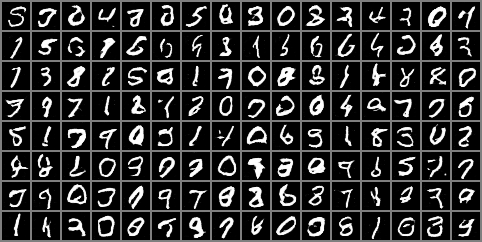

[5/5][300/468][247.4849 s]	Loss_D: -23.3058	Loss_G: 20.9914	Lip(D): 4.5853


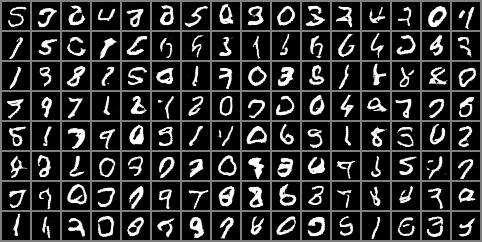

[5/5][400/468][258.8268 s]	Loss_D: -14.7927	Loss_G: 58.9140	Lip(D): 3.2829


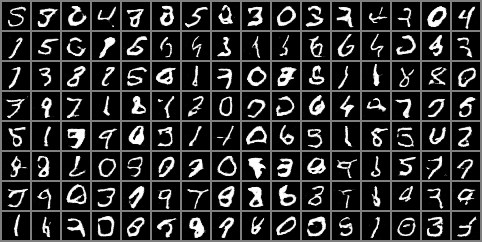

Total learning time =  266.48398303985596
Total learning time =  266.48599910736084


<All keys matched successfully>

In [33]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader, 0):
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        z = torch.randn(batch_size, nz, 1, 1, device=device)

        optimD.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = -torch.mean(D(real))
        fake_loss = torch.mean(D(faked))

        # Calculate gradient penalty with the renamed function
        gp_value = gpw * gradient_penalty(D, real, faked)

        # Total discriminator loss
        Dloss = real_loss + fake_loss + gp_value
        Dloss.backward()
        optimD.step()

        optimG.zero_grad()

        # Generator update
        gen_loss = -torch.mean(D(G(z)))
        gen_loss.backward()
        optimG.step()
        Gloss = gen_loss

        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch + 1, num_epochs, i, len(train_loader), time.time() - t0, Dloss.item(), Gloss.item(), lipconstant(D, real, faked)))
            show(G, zviz)

print('Total learning time = ', time.time() - t0)


print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [34]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())


<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

In [ ]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for k in np.arange(nk):
    ### ... ###

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset

In [ ]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

In [ ]:
### ... ###